In [ ]:
# importing the libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# libraries for text preprocessing (Natural Language Processing)
import nltk 
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from wordcloud import WordCloud

# tokenization and tf-idf 
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
import pickle 


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


link to the dataset: https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset?select=test.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train =  '/content/drive/MyDrive/Customer_Analytics_Project/Data/train.csv' 
test =  '/content/drive/MyDrive/Customer_Analytics_Project/Data/test.csv' 
train_df = pd.read_csv(train, encoding='latin-1') 
test_df = pd.read_csv(test, encoding='latin-1') 
# By providing the correct encoding, pandas can decode the file content properly, preventing the UnicodeDecodeError from occurring and allowing you to read your dataset successfully.
print(train_df.shape)
print(test_df.shape)

(27481, 10)
(4815, 9)


In [ ]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [ ]:
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


## Data Cleaning and Exploratory Analysis (EDA) 

In [ ]:
# Dropping the unused columns (removing everything except ''text'' and 'sentiment' columns)
train_df.drop(['textID','selected_text','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'], axis=1, inplace=True) # axis = 1 means dripping the columns and inplace means the data will be modified without returning a copy of the data.
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
# checking for nulls
train_df.isnull().sum() 

text         1
sentiment    0
dtype: int64

In [ ]:
# dropping the null that we have in column 'text'
train_df.dropna(inplace= True)

In [ ]:
# checking again for nulls 
train_df.isnull().sum()

text         0
sentiment    0
dtype: int64

Text(0.5, 1.0, 'Sentiment Data Distribution')

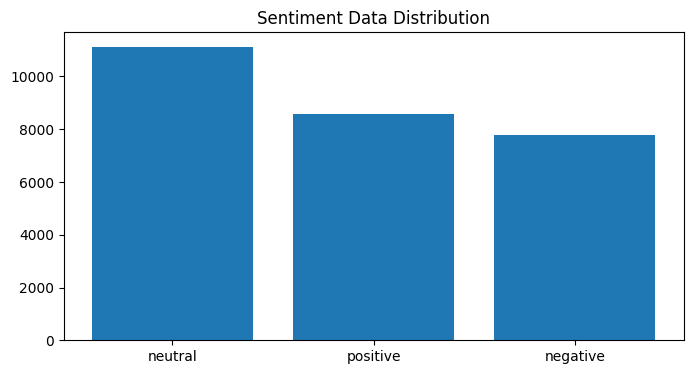

In [ ]:
# seeing the distribution of the sentiments in column 'sentiment' 
val_count = train_df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [ ]:
# seeing their length 
len(train_df[train_df["sentiment"] =="neutral" ]),\
len(train_df[train_df["sentiment"] =="positive" ]),\
len(train_df[train_df["sentiment"] =="negative" ])

(11117, 8582, 7781)

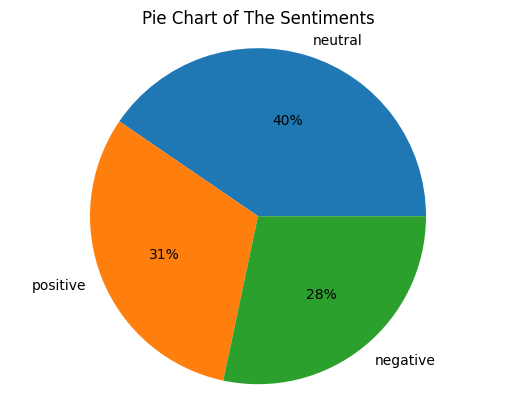

In [ ]:
# plotting them in a pie chart to see their percentages 
counts = train_df['sentiment'].value_counts()
plt.pie(counts, labels = counts.index, autopct='%.0f%%')
plt.title('Pie Chart of The Sentiments')
plt.axis('equal')
plt.show()

In [ ]:
# seeing the minimum length from the sentiments
min_length=  min(
    len(train_df[train_df["sentiment"] =="neutral" ]),
    len(train_df[train_df["sentiment"] =="positive" ]),
    len(train_df[train_df["sentiment"] =="negative" ])  
)
min_length

7781

In [ ]:
# take random samples from the data for each sample in the minimum range
sampled_neutral= train_df[train_df['sentiment']=='neutral'].sample(n=min_length)
sampled_positive= train_df[train_df['sentiment']=='positive'].sample(n=min_length)
sampled_negative= train_df[train_df['sentiment']=='negative'].sample(n=min_length)

In [ ]:
# this for having the labels reseted 
sampled_neutral=sampled_neutral.reset_index(drop=True)
sampled_positive=sampled_positive.reset_index(drop=True)
sampled_negative=sampled_negative.reset_index(drop=True)

In [ ]:
# now we will append them together to have a new balanced sentiment dataset
train_df2 = sampled_positive.append(sampled_neutral).append(sampled_negative).sample(frac=1).reset_index(drop=True)

<ipython-input-16-14091d2d5c8d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df2 = sampled_positive.append(sampled_neutral).append(sampled_negative).sample(frac=1).reset_index(drop=True)


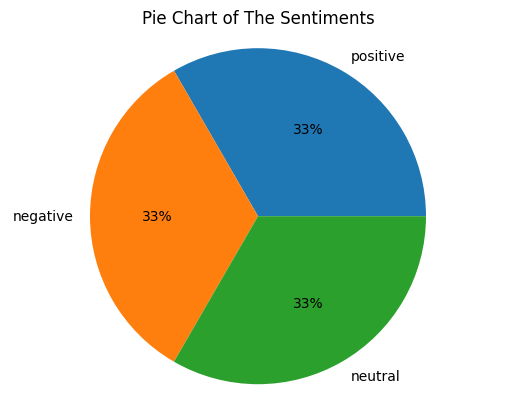

(7781, 7781, 7781)

In [ ]:
# checking the balanced dataset with a pie chart
# plotting them in a pie chart to see their percentages 
counts = train_df2['sentiment'].value_counts()
plt.pie(counts, labels = counts.index, autopct='%.0f%%')
plt.title('Pie Chart of The Sentiments')
plt.axis('equal')
plt.show()
len(train_df2[train_df2["sentiment"] =="neutral" ]),\
len(train_df2[train_df2["sentiment"] =="positive" ]),\
len(train_df2[train_df2["sentiment"] =="negative" ])

In [ ]:
print(train_df2.shape)
train_df2.head()

(23343, 2)


,text,sentiment
0,I gave a homeless lady named Ruby an Ice Cream...,positive
1,dude i will check again but i couldnt find a...,negative
2,Yeah! I want it too. I love that 'Falling Slo...,positive
3,now cash u kno I`m not a hater.....jus upset ...,negative
4,then you must insist you write essays the twi...,neutral


## Feature Extraction (FE)

Tweet messages commonly contain hyperlink texts, hashtags, emoticons, upercase, and punctuation marks. When utilizing them to train a Language Model, it is essential to exclude such texts from the training data. Hence, it is necessary to perform text data cleaning using various preprocessing and cleansing techniques. 

Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are...

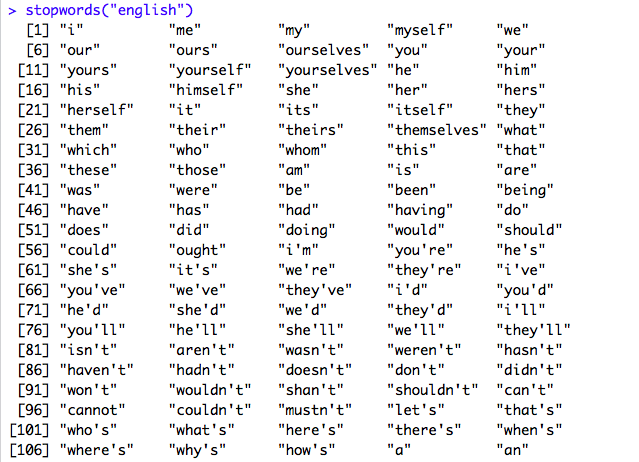

The goal of lemmatization is to transform words into their standard or base form, so it helps in the reduction of words to a common representation and the capture of their core meaning. For example, lemmatization of the words "running" and "ran" would provide the basic form "run."

In [ ]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_text(df, column_name):
    # initialize WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # regular expressions to match patterns to be removed
    hashtag_pattern = r'#\w+'
    hyperlink_pattern = r'http\S+'
    emoticon_pattern = r'(?::|;|=)(?:-)?(?:\)|\(|D|P)'

    # load english stopwords
    stop_words = set(stopwords.words('english'))

    # function to perform the cleaning operations
    def clean_and_lemmatize_text(text):
        # remove hashtags
        text = re.sub(hashtag_pattern, '', text)

        # remove hyperlinks
        text = re.sub(hyperlink_pattern, '', text)

        # remove emoticons
        text = re.sub(emoticon_pattern, '', text)

        # convert to lowercase
        text = text.lower()
        
        # remove repetitive characters
        text = re.sub(r'(.)\1+', r'\1', text)

        # remove everything that is not a letter
        text = re.sub(r'[^a-zA-Z]', ' ', text)

        # remove stopwords
        text = ' '.join([word for word in text.split() if word not in stop_words])

        # lemmatize the text
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

        return text

    # apply the cleaning function to the specified column
    df['cleaned_text'] = df[column_name].apply(clean_and_lemmatize_text)

    return df

In [ ]:
train_df2 = clean_text(train_df2, 'text')

In [ ]:
train_df2.head()

,text,sentiment,cleaned_text
0,I gave a homeless lady named Ruby an Ice Cream...,positive,gave homeles lady named ruby ice cream sandwic...
1,dude i will check again but i couldnt find a...,negative,dude wil check couldnt find anything haha capi...
2,Yeah! I want it too. I love that 'Falling Slo...,positive,yeah want love faling slowly song keps playing...
3,now cash u kno I`m not a hater.....jus upset ...,negative,cash u kno hater jus upset update yet
4,then you must insist you write essays the twi...,neutral,must insist write esays twiter way character


worldcloud (positive words)

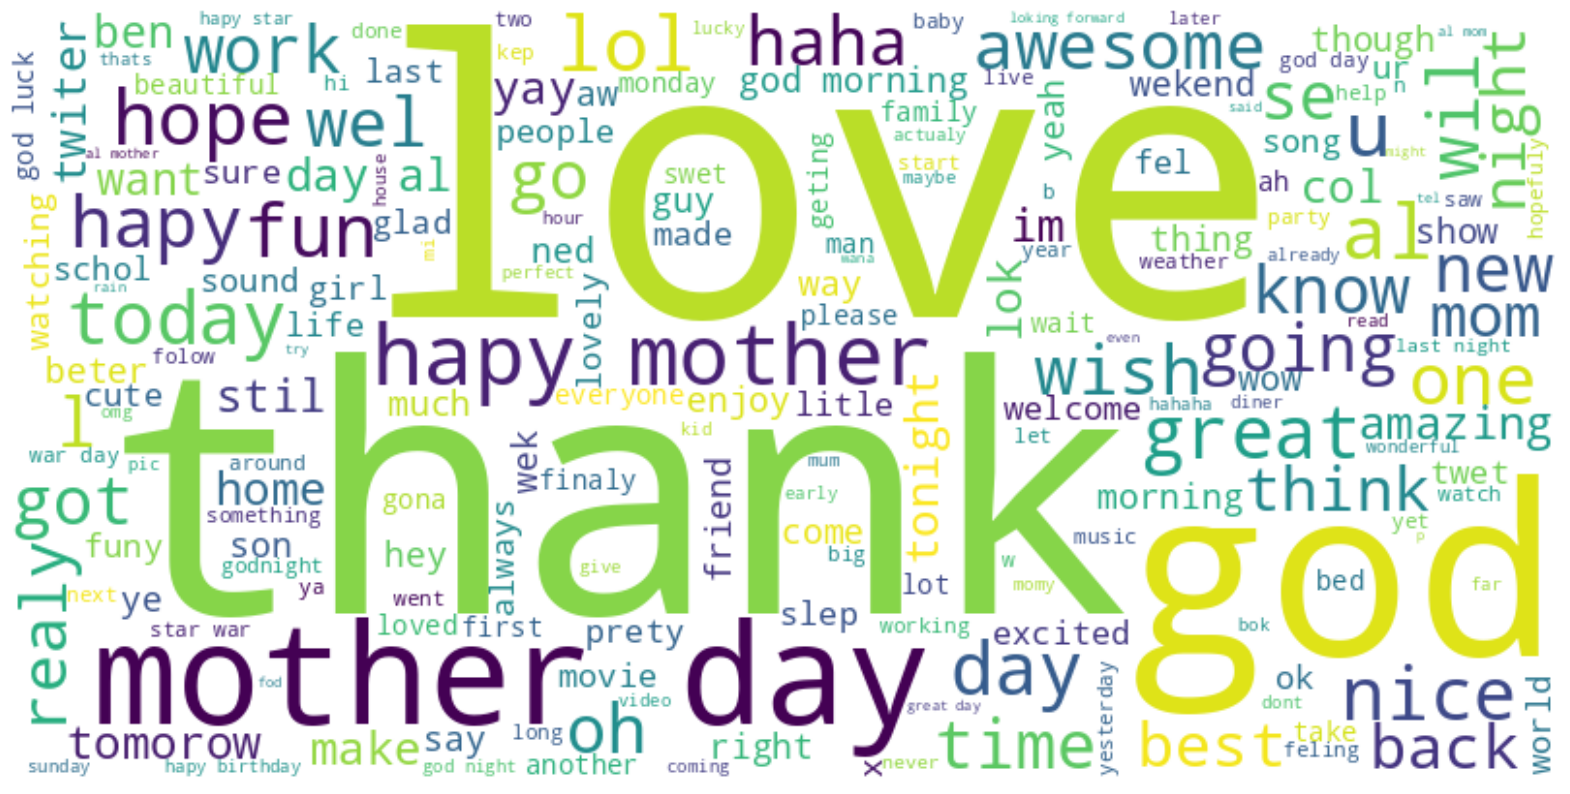

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(width = 800 , height = 400, background_color = 'white' ).generate(" ".join(train_df2[train_df2.sentiment == 'positive'].cleaned_text))
plt.axis('off')
plt.imshow(wc , interpolation = 'bilinear')

worldcloud (neutral words)

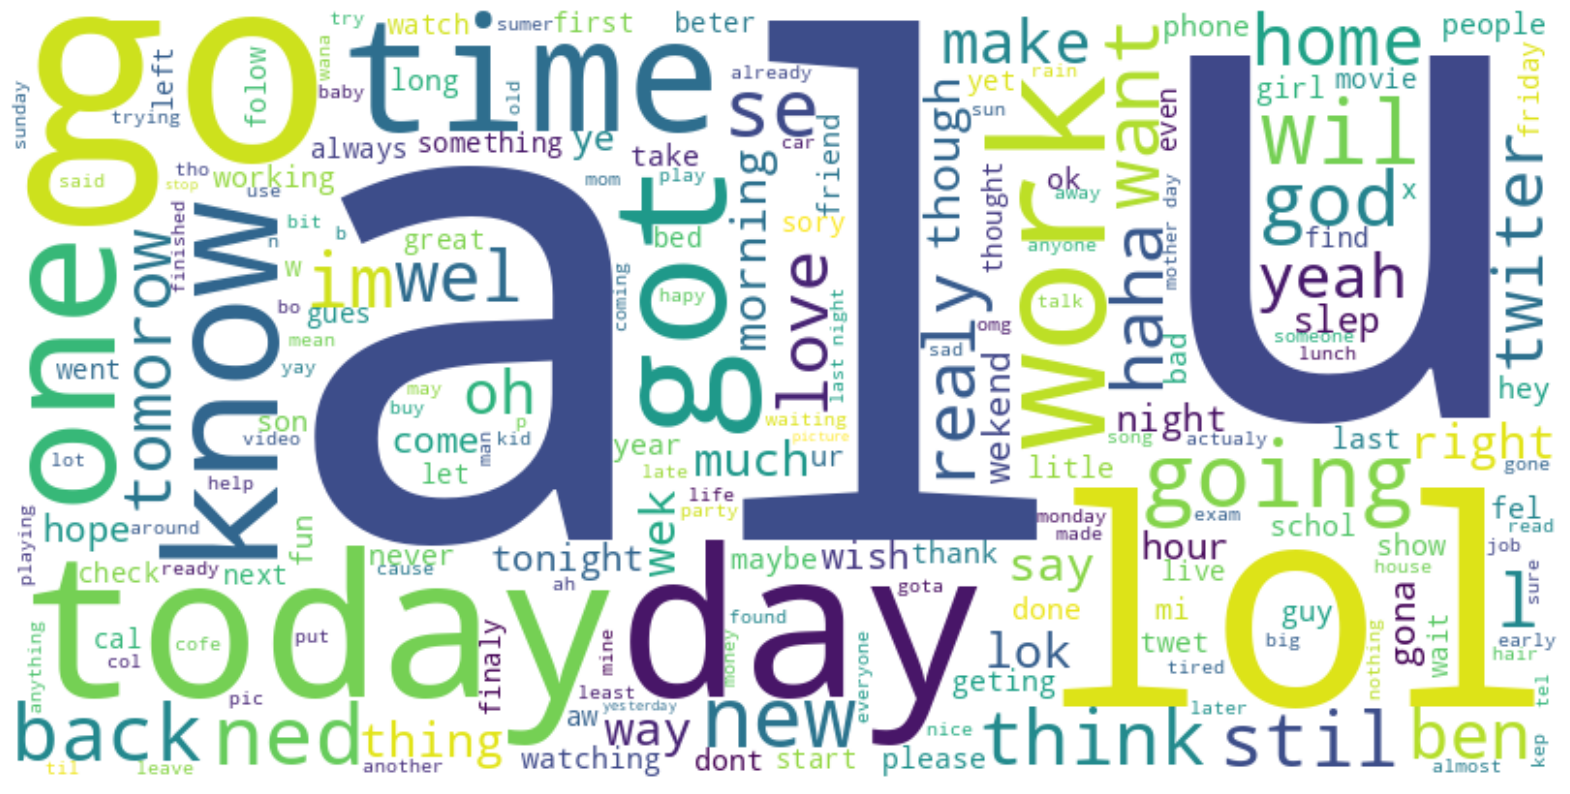

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(width = 800 , height = 400, background_color = 'white' ).generate(" ".join(train_df2[train_df2.sentiment == 'neutral'].cleaned_text))
plt.axis('off')
plt.imshow(wc , interpolation = 'bilinear')

worldcloud (negative words)

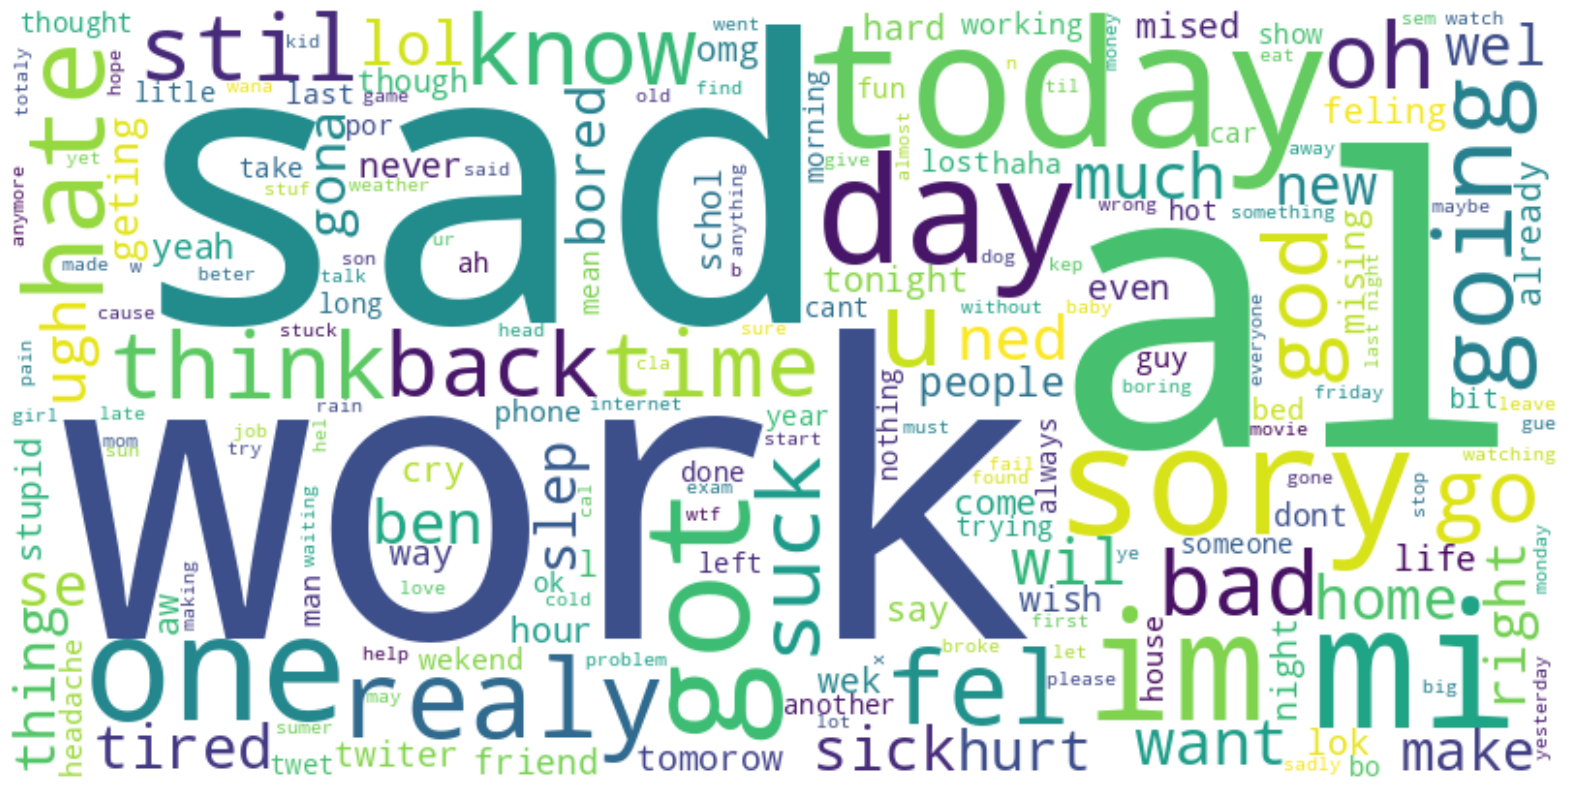

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(width = 800 , height = 400, background_color = 'white' ).generate(" ".join(train_df2[train_df2.sentiment == 'negative'].cleaned_text))
plt.axis('off')
plt.imshow(wc , interpolation = 'bilinear')

## Tokanization

Tokenization is the process of breaking down a given text into smaller pieces known as tokens, which can include individual words, phrases, or even entire sentences. Certain characters, such as punctuation marks, may be removed during the tokenization process.

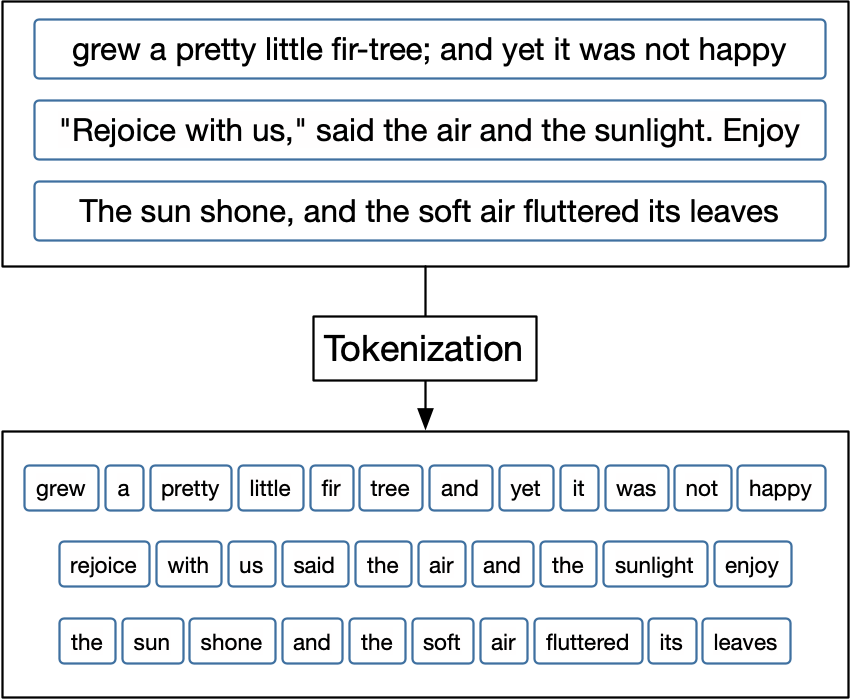

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df2.cleaned_text)
tokenized_text = tokenizer.texts_to_sequences(train_df2.cleaned_text)
tokenized_cleaned_text = tokenizer.sequences_to_texts(tokenized_text)
train_df2['cleaned_text'] = tokenized_cleaned_text

In [ ]:
train_df2.head()

,text,sentiment,cleaned_text
0,I gave a homeless lady named Ruby an Ice Cream...,positive,gave homeles lady named ruby ice cream sandwic...
1,dude i will check again but i couldnt find a...,negative,dude wil check couldnt find anything haha capi...
2,Yeah! I want it too. I love that 'Falling Slo...,positive,yeah want love faling slowly song keps playing...
3,now cash u kno I`m not a hater.....jus upset ...,negative,cash u kno hater jus upset update yet
4,then you must insist you write essays the twi...,neutral,must insist write esays twiter way character


## Creating and Evaluating the Models

Training model for positive and negative sentiments

In [ ]:
 # we removed the neutral and kept the positive and negative to train the model on them
df2_pn = train_df2[train_df2["sentiment"] != "neutral"]
df2_pn["sentiment"].value_counts()

positive    7781
negative    7781
Name: sentiment, dtype: int64

In [ ]:
X= df2_pn['cleaned_text']
y= df2_pn['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

The TF-IDF vectorizer helps in capturing the importance of words in conveying emotion in sentiment analysis. Words that are more frequently used in one text but less common in all of the texts are likely to convey more sentiment-related information. The TF-IDF vectorizer enhances the relevance of certain words in sentiment analysis by applying larger weights to them. The text data is transformed into a numerical representation via the TF-IDF vectorizer, with each document represented by a vector of TF-IDF values for each word. These vectors may then be utilized as input characteristics for sentiment analysis using machine learning models such as logistic regression.

In [ ]:
vectorizer =TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True, max_df=0.5, stop_words=None, use_idf=True)

X_train = vectorizer.fit_transform(X_train.values.astype('U'))

X_test = vectorizer.transform(X_test.values.astype('U'))

In [ ]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
print("score on training data:")
print(lr.score(X_train, y_train))
print("_" *100)
print("score on testing data:")
pred_y = lr.predict(X_test)
print('1. accuracy_ score')
print(accuracy_score(y_test, pred_y))
print("2. f1_score:")
print(f1_score(y_test, pred_y, average = 'macro'))

score on training data:
0.9559000722949634
____________________________________________________________________________________________________
score on testing data:
1. accuracy_ score
0.8689367169932541
2. f1_score:
0.868936054286988


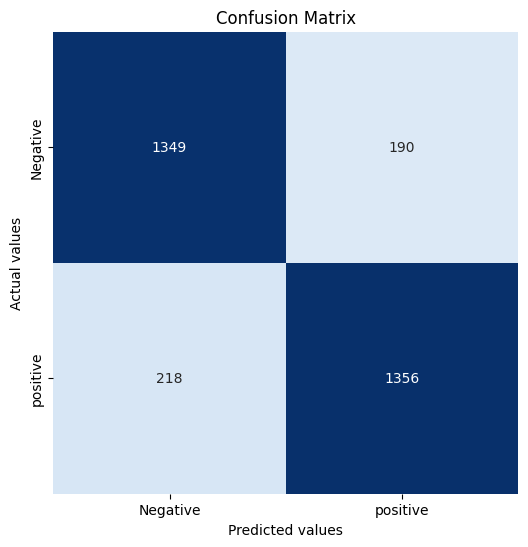

Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.88      0.87      1539
    positive       0.88      0.86      0.87      1574

    accuracy                           0.87      3113
   macro avg       0.87      0.87      0.87      3113
weighted avg       0.87      0.87      0.87      3113



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, pred_y)
clr =classification_report(y_test, pred_y)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["Negative", "positive"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["Negative", "positive"])
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", clr)

Now, training the model for neutral and non-neutral (positive and negative) for the unbalanced data. because we want to combine negatives and postives 

In [ ]:
train_df = clean_text(train_df, 'text')
tokenizer.fit_on_texts(train_df.cleaned_text)

In [ ]:
# going back to the unbalanced data and naming each class alone
positive_data = train_df[train_df['sentiment']=='positive'].dropna()
negative_data= train_df[train_df['sentiment']=='negative'].dropna()
neutral_data= train_df[train_df['sentiment']=='neutral'].dropna()
print(len(positive_data))
print(len(negative_data))
print(len(neutral_data))

8582
7781
11117


In [ ]:
# we want to seperate the data between neutral and non neautral so that we let the model learn 
non_neutral_data = positive_data.append(negative_data).sample(frac=1).reset_index(drop =True)
non_neutral_data['sentiment']='NonNeutral'

<ipython-input-35-41ab9bf547a3>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_neutral_data = positive_data.append(negative_data).sample(frac=1).reset_index(drop =True)


In [ ]:
# now we append both the neutral and non neutral data 
neutral_df2 = neutral_data.append(non_neutral_data).sample(frac=1).reset_index(drop =True)
neutral_df2

<ipython-input-36-9ef8af5265f3>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neutral_df2 = neutral_data.append(non_neutral_data).sample(frac=1).reset_index(drop =True)


,text,sentiment,cleaned_text
0,just got home from the sunshine coast,neutral,got home sunshine coast
1,dam living in england x,neutral,dam living england x
2,I don`t feel good. .My throat hurts!!!!,NonNeutral,fel god throat hurt
3,When are gonna release another album already?...,NonNeutral,gona release another album already mi
4,"I was seeing only one side of it, but it loo...",NonNeutral,seing one side loked interesting dep
...,...,...,...
27475,i wish you still loved me,NonNeutral,wish stil loved
27476,left. so sad. waiting for mom to come home. ...,NonNeutral,left sad waiting mom come home want papa john ...
27477,So I was just angrily told I was extemely abus...,NonNeutral,angrily told extemely abusive mentaly emotiona...
27478,Are you shattered after that long week? That...,neutral,shatered long wek thats pity tomorow night


In [ ]:
neutral_df2['sentiment'].value_counts()

NonNeutral    16363
neutral       11117
Name: sentiment, dtype: int64

In [ ]:
# we need to balance between neutral and non neautral as we did previously
counts =neutral_df2['sentiment'].value_counts()
min_count = counts.min()
balanced_df2 = neutral_df2.groupby('sentiment').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

In [ ]:
balanced_df2['sentiment'].value_counts()

NonNeutral    11117
neutral       11117
Name: sentiment, dtype: int64

In [ ]:
X2= balanced_df2['cleaned_text']
y2= balanced_df2['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=0)

In [ ]:
vectorizer2 =TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True, max_df=0.5, stop_words=None, use_idf=True)

X_train = vectorizer2.fit_transform(X_train.values.astype('U'))

X_test = vectorizer2.transform(X_test.values.astype('U'))

In [ ]:
lr2 = LogisticRegression(random_state=0)
lr2.fit(X_train,y_train)
print("score on training data:")
print(lr2.score(X_train, y_train))
print("_" *100)
print("score on testing data:")
pred_y = lr2.predict(X_test)
print('1. accuracy_ score')
print(accuracy_score(y_test, pred_y))
print("2. f1_score:")
print(f1_score(y_test, pred_y, average = 'macro'))

score on training data:
0.886771237420588
____________________________________________________________________________________________________
score on testing data:
1. accuracy_ score
0.7015965819653699
2. f1_score:
0.7015927190506379


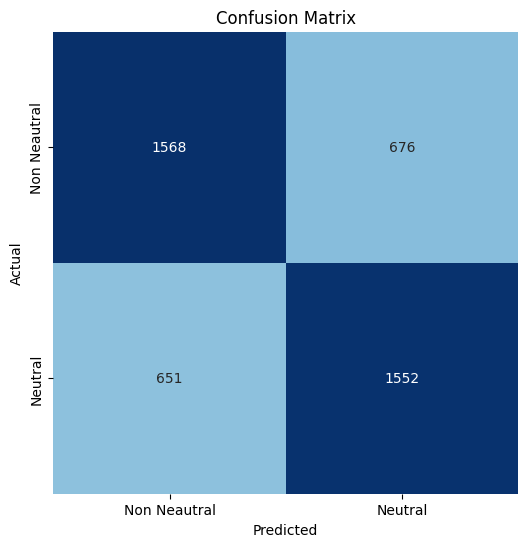

Classification Report:
               precision    recall  f1-score   support

  NonNeutral       0.71      0.70      0.70      2244
     neutral       0.70      0.70      0.70      2203

    accuracy                           0.70      4447
   macro avg       0.70      0.70      0.70      4447
weighted avg       0.70      0.70      0.70      4447



In [ ]:
cm2 = confusion_matrix(y_test, pred_y)
clr2 =classification_report(y_test, pred_y)
plt.figure(figsize=(6, 6))
sns.heatmap(cm2, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["Non Neautral", "Neutral"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["Non Neautral", "Neutral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", clr2)

In [ ]:
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
pickle.dump(lr, open('lr.pkl', 'wb'))

vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))
model = pickle.load(open('lr.pkl', 'rb'))

In [ ]:
pickle.dump(vectorizer2, open('vectorizer2.pkl', 'wb'))
pickle.dump(lr2, open('lr2.pkl', 'wb'))

vectorizer2 = pickle.load(open('vectorizer2.pkl', 'rb'))
model2 = pickle.load(open('lr2.pkl', 'rb'))

In [ ]:
def predict_multi_level(text, vectorizer2, model2, vectorizer, model):

    neu_y_pred = model2.predict(vectorizer2.transform(text))
    if len(text[neu_y_pred == 'NonNeutral']) > 0:
        y_pred = model.predict(vectorizer.transform(text[neu_y_pred == 'NonNeutral'])) # classify non neutral into positive or negative
        neu_y_pred[neu_y_pred == 'NonNeutral'] = y_pred
    
    final_y_pred = neu_y_pred
    return final_y_pred

In [ ]:
test_df.dropna(inplace=True)

In [ ]:
test_df = clean_text(test_df,'text')

In [ ]:
X = test_df['cleaned_text']
pred = predict_multi_level(X, vectorizer2, model2, vectorizer, model)
test_df['pred_Sentiment'] = pred

In [ ]:
print(accuracy_score(test_df['sentiment'], test_df['pred_Sentiment']))
print(classification_report(test_df['sentiment'], test_df['pred_Sentiment']))

0.677985285795133
              precision    recall  f1-score   support

    negative       0.68      0.56      0.61      1001
     neutral       0.62      0.74      0.67      1430
    positive       0.77      0.71      0.74      1103

    accuracy                           0.68      3534
   macro avg       0.69      0.67      0.68      3534
weighted avg       0.69      0.68      0.68      3534



In [ ]:
def predict_sentiment(X, vectorizer2, model2, vectorizer, model,  stem=False):
  df = pd.DataFrame({'text': X})
  # Clean the text
  cleaned_text = clean_text(df, 'text')
    
  # Perform multi-level sentiment prediction
  sentiment_prediction = predict_multi_level(cleaned_text['cleaned_text'], vectorizer2, model2, vectorizer, model)
    
  return sentiment_prediction.tolist()

In [ ]:
ans=predict_sentiment(["how are you"], vectorizer2, model2, vectorizer, model, stem=False)
print(ans)

['neutral']


In [ ]:
ans=predict_sentiment(["i dont know"], vectorizer2, model2, vectorizer, model, stem=False)
print(ans)

['neutral']


In [ ]:
ans=predict_sentiment(["i love this"], vectorizer2, model2, vectorizer, model, stem=False)
print(ans)

['positive']


In [ ]:
ans=predict_sentiment(["i am happy"], vectorizer2, model2, vectorizer, model, stem=False)
print(ans)

['positive']


In [ ]:
ans=predict_sentiment(["i am sad"], vectorizer2, model2, vectorizer, model, stem=False)
print(ans)

['negative']


In [ ]:
ans=predict_sentiment(["i dont like this"],vectorizer2, model2, vectorizer, model, stem=False)
print(ans)

['negative']
